Dont use gpu while executing this notebook, it takes time and might interrupt the program

In [1]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Important headers
import scipy.io
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import cmath
import pdb
from scipy import fftpack
from scipy.fftpack import fft

In [3]:
#Global variables
global phase
global a
global b
global c

Functions

In [4]:
'''
Input : different bands of the trial
output : MSC values of the trial
'''
#unfiltered msc# Called in MSC function
def uMSC(Channel_1,Channel_2):
  f, Cxy = signal.coherence(Channel_1, Channel_2, 200, nperseg=1024)
  return f,Cxy
#filtered msc for alpha, beta and gamma

def MSC(alp,bet,gam):
  final_msc_alpha = {}        #alpha beta gamma msc values of a trial
  final_msc_beta = {}
  final_msc_gamma = {}
  for k in range(62):
    for j in range(62):       #for all 62 channels

      f_alp, Cxy_alp = uMSC(alp[k],alp[j])
      f_bet, Cxy_bet = uMSC(bet[k],bet[j])
      f_gam, Cxy_gam = uMSC(gam[k],gam[j])
      final_msc_alpha[(k,j)] = np.sum(Cxy_alp)/len(Cxy_alp)
      final_msc_beta[(k,j)] = np.sum(Cxy_bet)/len(Cxy_bet)
      final_msc_gamma[(k,j)] = np.sum(Cxy_gam)/len(Cxy_gam)
  return final_msc_alpha,final_msc_beta,final_msc_gamma


In [15]:
'''
Input : eeg data of the trial
output : different bands of the trial
'''
def get_bands(matrix):
  filtered_alpha=[]
  filtered_beta=[]
  filtered_gamma=[]
  arr=matrix

  sos_alpha = signal.butter(10, [8,13], 'bp', fs=200, output='sos')
  filtered_alpha=signal.sosfilt(sos_alpha, arr)
  sos_beta = signal.butter(10, [13,30], 'bp', fs=200, output='sos')
  filtered_beta=signal.sosfilt(sos_beta, arr)
  sos_gamma = signal.butter(10, [30,75], 'bp', fs=200, output='sos')
  filtered_gamma=signal.sosfilt(sos_gamma, arr)

  print('length of the filtered alpha band is ', len(filtered_alpha))
  print('\nlength of the filtered beta band is ',len(filtered_beta))
  print('\nlength of the filtered Gamma band is ',len(filtered_gamma))

#Data Augmentation through sliding window approach. Delete this portion if not needed. In the paper titled 'Emotion detection from
#EEG using transfer learning' this portion was not included. This was added later in the future experiments

  # Set window size and stride
  window_size = 3700 #Dependent on your data
  stride = 1850 # use according to your usage of overlapping or non overlapping windows

  # Calculate number of subarrays
  num_subarrays_alpha = ((filtered_alpha.shape[1] - window_size) // stride) + 1
  num_subarrays_beta = ((filtered_beta.shape[1] - window_size) // stride) + 1
  num_subarrays_gamma = ((filtered_gamma.shape[1] - window_size) // stride) + 1

  # Initialize array to hold subarrays
  subarrays_alpha = np.zeros((num_subarrays_alpha, 62, window_size))
  subarrays_beta = np.zeros((num_subarrays_beta, 62, window_size))
  subarrays_gamma = np.zeros((num_subarrays_gamma, 62, window_size))

  # Fill array with subarrays using sliding window
  for i in range(num_subarrays_alpha):
      start_index = i * stride
      end_index = start_index + window_size
      subarrays_alpha[i] = filtered_alpha[:, start_index:end_index]
  for i in range(num_subarrays_beta):
      start_index = i * stride
      end_index = start_index + window_size
      subarrays_beta[i] = filtered_beta[:, start_index:end_index]
  for i in range(num_subarrays_gamma):
      start_index = i * stride
      end_index = start_index + window_size
      subarrays_gamma[i] = filtered_gamma[:, start_index:end_index]
  return subarrays_alpha, subarrays_beta, subarrays_gamma

In [16]:
#Obtaining Phase through hilbert transform
'''
Input : filtered time series bands of the trial
output : phase of the signal
'''

def Phase_calc(x):
  phase=[]
  z=scipy.signal.hilbert(x, N=None, axis=- 1)
  inst_phase = (np.unwrap(np.angle(z)))#inst phase
  inst_freq = np.diff(inst_phase)/(2*np.pi)*200 #inst frequency
  phase.append(inst_phase)
  return phase

In [17]:
#Getting the MPC values
'''
Input : phase values of the trial
output : MPC matrix of the trial
'''

def MPC_Matrix(phase):#if needed input phase to this function "def MPC_Matrix(phase)".
  for o in range(0,1):
    mpc=[]
    for i in range(0,62): #Change according to the number of channels
      mpcik=0
      for k in range(i, 62): #Change according to the number of channels
        mpcik = mpcik + abs(np.sum(np.exp(-1*cmath.sqrt(-1)*(phase[o][i]-phase[o][k]))))
        mpcikf= (1/3700)*mpcik #Change according to the window length
        mpc.append(mpcikf)
        mpcikf=mpcik=0
    return mpc


Load the dataset

In [19]:
#Loading the dataset
matfiles=[]
path='/content/drive/MyDrive/dataset/SEED_EEG/SEED_EEG/Preprocessed_EEG' #provide the path to SEED EEG dataset
files=os.listdir(path)
for index in range(len(files)):
  if files[index].endswith('.mat'):
    matfiles.append(files[index])


Generating images

/content/drive/MyDrive/dataset/SEED_EEG/SEED_EEG/Preprocessed_EEG/1_20131027.mat
eeg data of key0 
 [[-11.62290573 -16.21246338 -17.13633537 ...  -4.14252281  -4.529953
   -2.05636024]
 [ 14.93096352   8.07642937   8.19563866 ...  31.44145012  34.00444984
   37.72974014]
 [ 38.05756569  25.57039261  37.99796104 ...  37.04428673  34.481287
   40.4715538 ]
 ...
 [ 24.25909042  15.49720764  21.51727676 ...  17.49396324  16.30187035
    2.2649765 ]
 [ 26.82209015  27.77576447  26.70288086 ...  22.67956734  24.2292881
   12.18914986]
 [ 29.77252007  33.55741501  30.39836884 ...  12.09974289   9.65595245
    2.86102295]] 
 shape= (62, 37001)
length of the filtered alpha band is  62

length of the filtered beta band is  62

length of the filtered Gamma band is  62



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-20-c323c8ca9397>(80)<cell line: 4>()
     78       #Saving the Images into respective classes. Refer SEED dataset for the information regarding classes.
     79 
---> 80       if j in [0,5,8,9,13]:
     81         print('hi')
     82         if os.path.exists('/content/drive/MyDrive/Neural_signal_processing/1')==False:

ipdb> plt.imshow(r_array)
ipdb> exit



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)



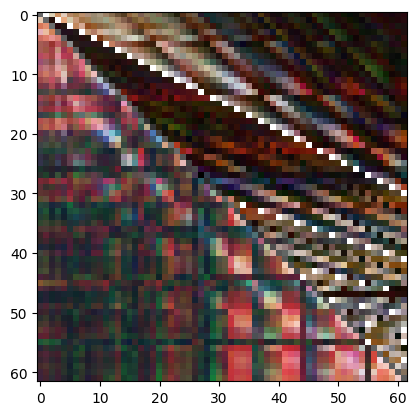

In [20]:
'''In the image, the upper triangle contains MPC values, diagonal contains DE values and lower
   triangle contains MSC values.'''

for index in range(len(matfiles)):
  name=matfiles[index].split('_')[0]
  matpath=os.path.join(path,matfiles[index])
  print(matpath)
  matrix=scipy.io.loadmat(matpath)
  keys=list(matrix.keys())[3:]
  for key in keys:
    matrix[key]=matrix[key][:,:37001] #samples are dependent on the sample size
  for j in range(len(keys)):
    eeg_data = matrix[keys[j]]
    print(f'eeg data of key{j}','\n',eeg_data,'\n','shape=',eeg_data.shape)
    data=eeg_data
    MPC={'alpha': [],'beta':[],'Gamma':[]}
    a,b,c=get_bands(data)
    for ingl in range(len(a)):
      place_holder1=Phase_calc(a[ingl])
      MPC['alpha'].append(MPC_Matrix(place_holder1))
      place_holder2=Phase_calc(b[ingl])
      MPC['beta'].append(MPC_Matrix(place_holder2))
      place_holder3=Phase_calc(c[ingl])
      MPC['Gamma'].append(MPC_Matrix(place_holder3))
      final_alpha,final_beta,final_gamma = MSC(a[ingl],b[ingl],c[ingl])
      mtrx_alpha=[]
      for i in range(0,62): #number of channels are variable, dependent on the data
        mtrx_alpha.append([0]*62)#number of channels are variable, dependent on the data
      mtrx_beta=[]
      for i in range(0,62):
        mtrx_beta.append([0]*62)#number of channels are variable, dependent on the data
      mtrx_gamma=[]
      for i in range(0,62):
        mtrx_gamma.append([0]*62)#number of channels are variable, dependent on the data
      l=0
      p=0
      for i in range(62):#number of channels are variable, dependent on the data
        for k in range(62):#number of channels are variable, dependent on the data
          if i<k:
            mtrx_alpha[i][k] = MPC['alpha'][0][l]
            mtrx_beta[i][k] = MPC['beta'][0][l]
            mtrx_gamma[i][k] = MPC['Gamma'][0][l]
            l=l+1
          elif i>k:
            mtrx_alpha[i][k] = final_alpha[(i,k)]
            mtrx_beta[i][k] = final_beta[(i,k)]
            mtrx_gamma[i][k] = final_gamma[(i,k)]
            p+=1

      #Adding DE
      # DE was already provided in the SEED_EEG dataset
      for i in range(62):#number of channels are variable, dependent on the data
        for k in range(62):#number of channels are variable, dependent on the data
          if i==k:
            de=scipy.io.loadmat(f'/content/drive/MyDrive/dataset/SEED_EEG/SEED_EEG/ExtractedFeatures/{matfiles[index]}')['de_movingAve1'] #Load the DE features from SEED dataset
            DE=[]
            for ele1 in range(len(de)):
              DE_sub=[]
              for ele2 in range(len(de[ele1])):
                DE_sub.append(np.mean(de[ele1][ele2]))
              DE.append(DE_sub)
            for iter in range(len(DE)):
              DE[iter]=np.mean(DE[iter])
            data_min = np.min(DE)
            data_max = np.max(DE)
            for iter in range(len(DE)):
              DE[iter] = (DE[iter]-data_min)/(data_max-data_min)
            mtrx_alpha[i][k] = DE[i]
            mtrx_beta[i][k] = DE[i]
            mtrx_gamma[i][k] = DE[i]
      mtrx_alpha=np.reshape(mtrx_alpha,(62,62))#number of channels are variable, dependent on the data
      mtrx_beta=np.reshape(mtrx_beta,(62,62))#number of channels are variable, dependent on the data
      mtrx_gamma=np.reshape(mtrx_gamma,(62,62))#number of channels are variable, dependent on the data
      r_array = np.dstack((mtrx_alpha,mtrx_beta,mtrx_gamma))
      r = Image.fromarray(np.uint8(r_array))

      #Saving the Images into respective classes. Refer SEED dataset for the information regarding classes.

      if j in [0,5,8,9,13]: #specific trials are dependent on the dataset
        print('hi')
        if os.path.exists('/content/drive/MyDrive/Neural_signal_processing/1')==False:
          os.mkdir('/content/drive/MyDrive/Neural_signal_processing/1')
        r.save(f'/content/drive/MyDrive/Neural_signal_processing/1/{name}_{j}_{i}.png')


      elif j in [1,4,7,10,12]:#specific trials are dependent on the dataset
        print('hello')
        if os.path.exists('/content/drive/MyDrive/Neural_signal_processing/0')==False:
          os.mkdir('/content/drive/MyDrive/Neural_signal_processing/0')
        r.save(f'/content/drive/MyDrive/Neural_signal_processing/0/{name}_{j}_{i}.png')

      elif j in [2,3,6,11,14]:#specific trials are dependent on the dataset
        print('who')
        if os.path.exists('/content/drive/MyDrive/Neural_signal_processing/-1')==False:
          os.mkdir('/content/drive/MyDrive/Neural_signal_processing/-1')
        r.save(f'/content/drive/MyDrive/Neural_signal_processing/-1/{name}_{j}_{i}.png')



